## Chapter 16 - Metric-Predicted Variable on One or Two Groups

src: https://github.com/JWarmenhoven/DBDA-python

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
import jax.random as random
import jax.numpy as jnp
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("darkgrid");
plt.rcParams['figure.dpi'] = 100
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# plt.style.use("dark_background")
# plt.style.use("ggplot")
# plt.style.use("seaborn-white")


In [2]:
import arviz as az
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t
from IPython.display import Image

color = '#87ceeb'

In [3]:
%load_ext watermark
%watermark -p pandas,numpy,matplotlib,seaborn,scipy,numpyro,jax

pandas    : 1.2.4
numpy     : 1.19.4
matplotlib: 3.4.1
seaborn   : 0.11.1
scipy     : 1.5.4
numpyro   : 0.6.0
jax       : 0.2.10



In [4]:
def medstat(v):
    v = v.sort()
    med = v[len(v)//2]
    mad = np.median(np.abs(v-med))
    mad_sd = 1.483 * mad
    return med, mad_sd

def print_abs_summary(d, keys=None):
    print(' Med MAD_SD')
    for k, v in d.items():
        if (keys is None) or (k in keys):
            med, mad_sd = medstat(v)
            print(f'{k:7} {med:+5.3f} {mad_sd:+5.3f}')

In [5]:
rngkey = random.PRNGKey(0)
rngkey, subkey = jax.random.split(rngkey)
rngkey

array([4146024105,  967050713], dtype=uint32)

In [52]:
def mcmcinf(model, args):
    # args: dict for model input arguments
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
    #
    mcmc.run(rngkey, **args)
    mcmc.print_summary(exclude_deterministic=True, prob=.8)
    return mcmc
#
def get_trace(mcmc, expand=True):
    dsam = mcmc.get_samples()
    d = {}
    for k in dsam.keys():
        if (dsam[k].ndim < 2) or (expand==False):
            d[k] = np.array(dsam[k])
        else:
            d[k] = np.expand_dims(dsam[k], axis=0)
               
    print([a.shape for k, a in d.items()])
    return d
#

### Data
- IQ scores from two groups.
- The two groups are of categorical data type.

In [7]:
df = pd.read_csv('Data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [8]:
df.head(2)

,Score,Group
0,102,Smart Drug
1,107,Smart Drug


In [9]:
# Mean and STD for each group
df.groupby('Group').aggregate(['mean', 'std', 'sum'])

Score                 
                  mean        std   sum
Group                                  
Placebo     100.035088  17.894497  5702
Smart Drug  107.841270  25.445201  6794

In [10]:
# Mean and STD for each group
sum(df.Group == 'Placebo'), sum(df.Group == 'Smart Drug')

(57, 63)

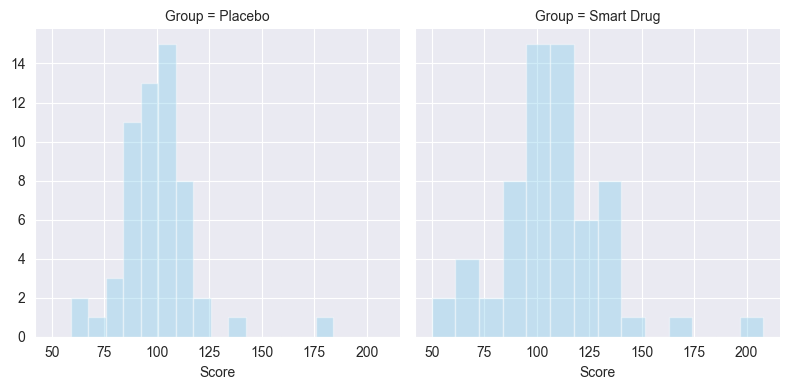

In [11]:
# see: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
fg = sns.FacetGrid(df, col='Group', height=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

#### Data for 16.1

In [12]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

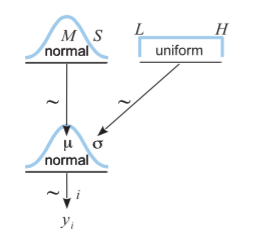

In [13]:
Image('images/fig16_2.png', width=400)

In [14]:
def model(y):
    ymean, ystd = y.mean(), y.std()
    
    mu = numpyro.sample('mu', dist.Normal(ymean, ystd))
    sigma = numpyro.sample('sigma', dist.Uniform(ystd/1000., ystd*1000))
    
    with numpyro.plate(f'y:{len(y)}', size=len(y)):
        obs = numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)

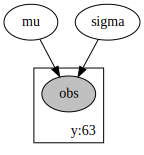

In [15]:
numpyro.render_model(model, model_args=(y.values,))

In [16]:
args = dict(y=y.values)
mcmc = mcmcinf(model, args)

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1036.62it/s, 3 steps of size 8.47e-01. acc. prob=0.92]



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        mu    107.85      3.30    107.83    103.49    111.88   7080.84      1.00
     sigma     25.92      2.36     25.76     22.78     28.62   8641.92      1.00

Number of divergences: 0


In [17]:
mcmc

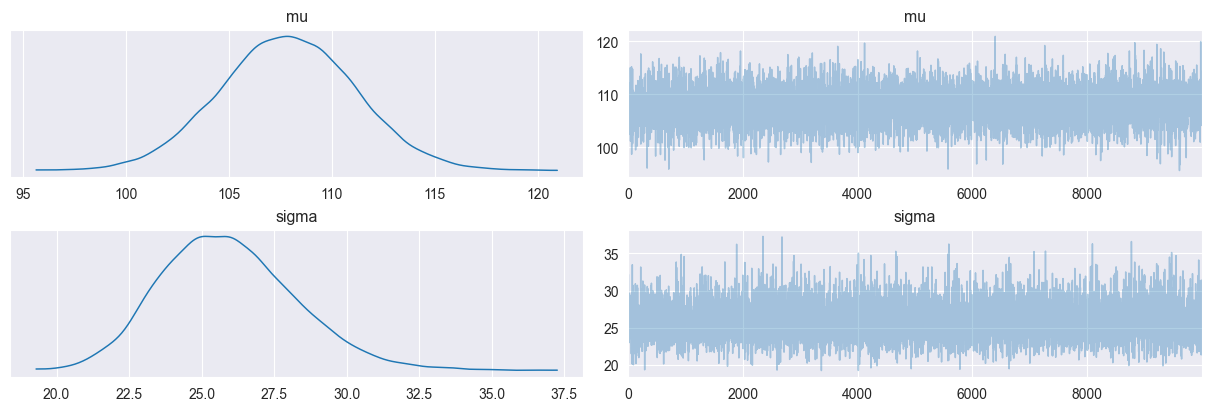

In [18]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace);

In [19]:
trace = get_trace(mcmc)

[(10000,), (10000,)]


#### Figure 16.3

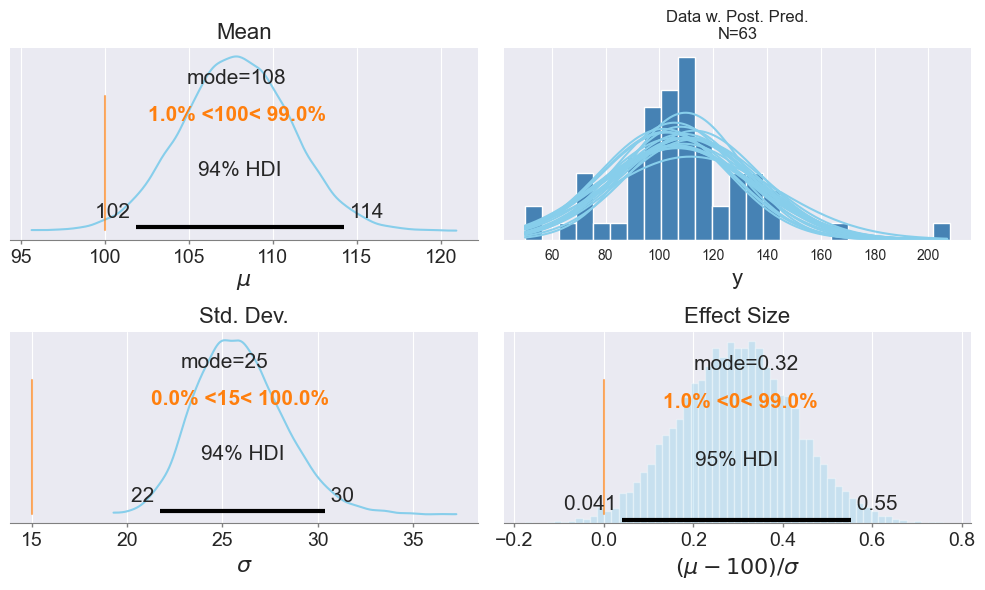

In [20]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

font_d = {'size':16}

# Upper left
az.plot_posterior(trace['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace['mu'])
# Plot only 20 posterior prediction curves. 
n_curves = 20
# Create an index of length 20 with which we step through the trace.
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c=color)
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
az.plot_posterior(trace['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Lower right
az.plot_posterior((trace['mu']-100)/trace['sigma'], point_estimate='mode', ref_val=0,
                  hdi_prob=0.95,
                  ax=ax4, color=color, kind='hist')
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

plt.tight_layout();

### 16.2 - Outliers and robust estimation: the t distribution

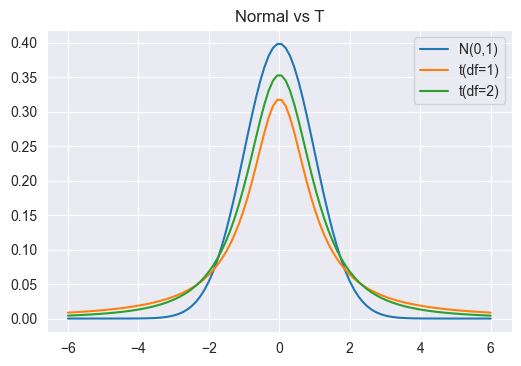

In [21]:
import scipy.stats as stats
x=np.linspace(-6,6,100)
plt.plot(x, stats.norm(loc=0,scale=1).pdf(x), label='N(0,1)')
plt.plot(x, stats.t(df=1, loc=0, scale=1).pdf(x), label='t(df=1)')
plt.plot(x, stats.t(df=2, loc=0, scale=1).pdf(x), label='t(df=2)')
# plt.plot(x, stats.t(df=100, loc=0, scale=1).pdf(x), label='t(df=100)')
plt.title('Normal vs T')
plt.legend();

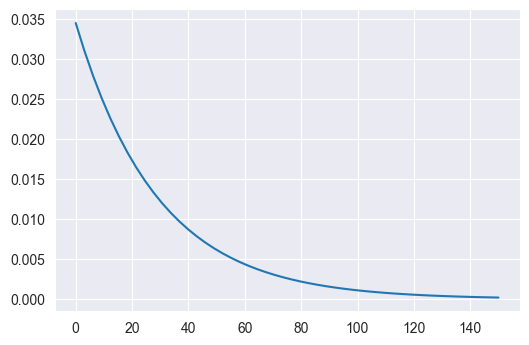

In [22]:
scale=29. # intended mean
x = np.linspace(0, 150)
z = np.linspace(0, 2.5, 100)
dexp = stats.expon(scale=scale)
plt.plot(x, dexp.pdf(x));

In [23]:
s = 1 + dexp.rvs(100000);
ls = np.log10(s)

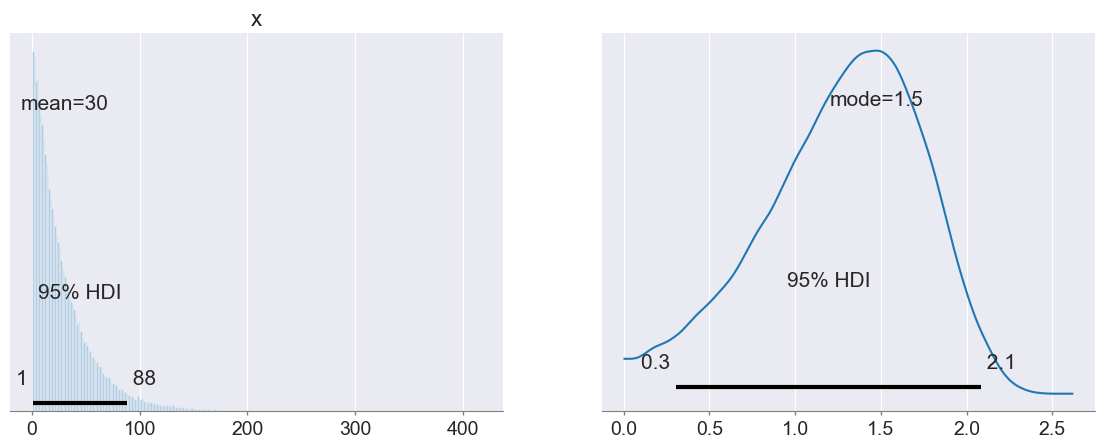

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
az.plot_posterior(s, ax=ax1, kind='hist', hdi_prob=.95)
az.plot_posterior(ls, ax=ax2, hdi_prob=.95, point_estimate='mode');
ax2.set_title(None);

#### Model

In [25]:
def model2(y):
    ym, ys = y.mean(), y.std()
    
    mu = numpyro.sample('mu', dist.Normal(ym, ys))
    sigma = numpyro.sample('sigma', dist.Uniform(ys/1000., ys*1000))
    nu_minus1 = numpyro.sample('nu_m1', dist.Exponential(1./29))
    nu = numpyro.deterministic('nu', nu_minus1 + 1)  # nu > 1
    
    with numpyro.plate(f'y:{len(y)}', size=len(y)):
        obs = numpyro.sample('obs', dist.StudentT(df=nu, loc=mu, scale=sigma), obs=y)

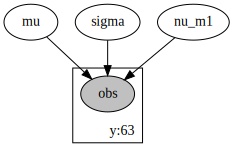

In [26]:
numpyro.render_model(model2, model_args=(y.values,))

In [27]:
mcmc2 = mcmcinf(model2, args)

sample: 100%|██████████| 11000/11000 [00:11<00:00, 936.75it/s, 7 steps of size 4.79e-01. acc. prob=0.93]  



                mean       std    median     10.0%     90.0%     n_eff     r_hat
        mu    107.22      2.82    107.19    103.77    110.95   6461.32      1.00
     nu_m1      9.17     14.18      4.55      0.41     11.61   4263.16      1.00
     sigma     19.85      3.54     19.75     15.39     24.45   4066.61      1.00

Number of divergences: 0


[(10000,), (10000,), (10000,), (10000,)]


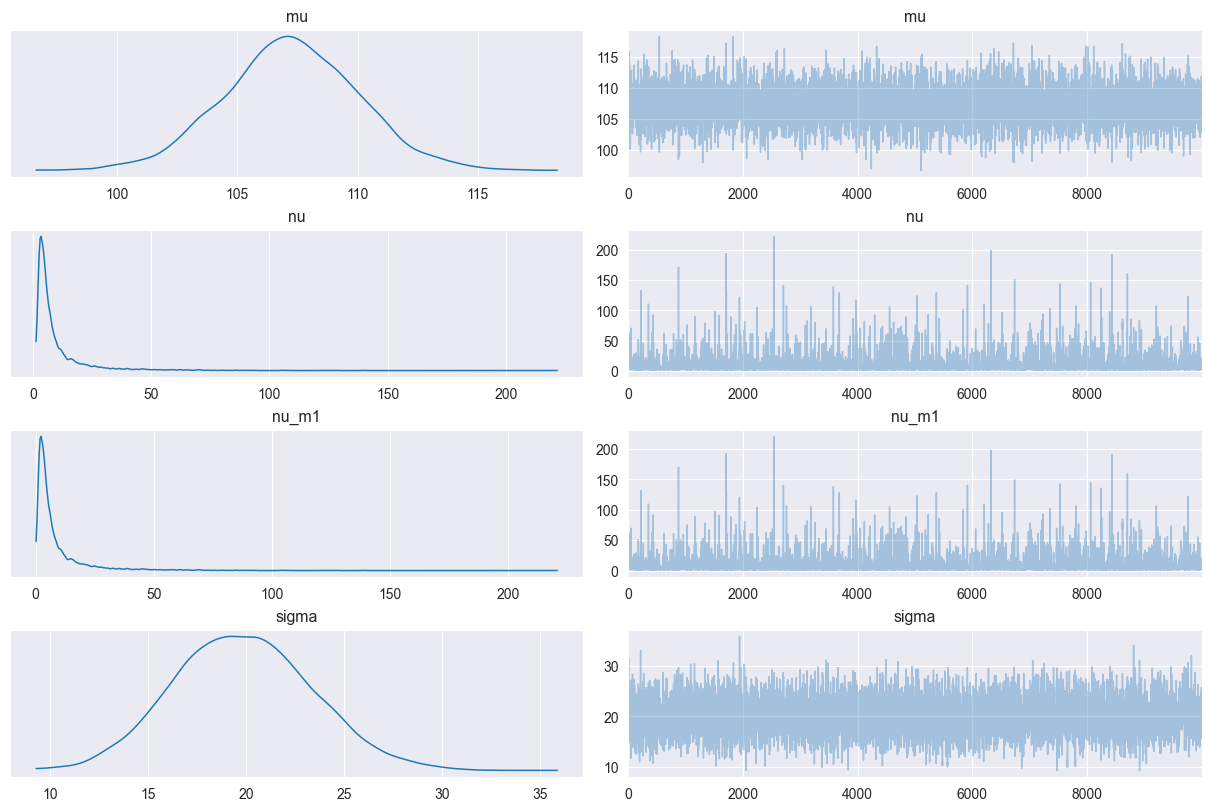

In [28]:
trace2 = get_trace(mcmc2)
az.plot_trace(trace2);

#### Figure 16.9

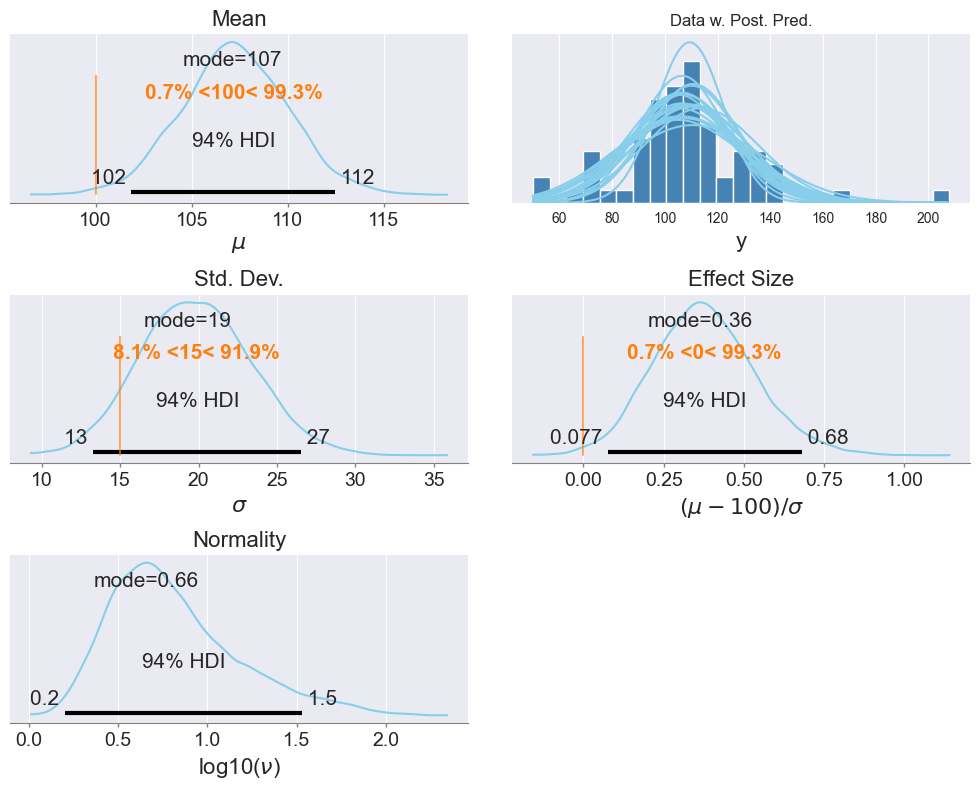

In [29]:
fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,8))

# Upper left
az.plot_posterior(trace2['mu'], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict=font_d)
ax1.set_title('Mean', fontdict=font_d)

# Upper right
tr_len = len(trace2['mu'])
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, density=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2['mu'][stepIdxVec], trace2['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict=font_d)
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
az.plot_posterior(trace2['sigma'], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict=font_d)
ax3.set_title('Std. Dev.', fontdict=font_d)

# Middle right
az.plot_posterior((trace2['mu']-100)/trace2['sigma'], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict=font_d)
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict=font_d)

# Lower left
az.plot_posterior(np.log10(trace2['nu']), point_estimate='mode', ax=ax5, color=color)
ax5.set_title('Normality', fontdict=font_d)
ax5.set_xlabel(r'log10($\nu$)', fontdict=font_d)

plt.tight_layout();
ax6.set_visible(False)

In [30]:
nu_mode = az.plots.plot_utils.calculate_point_estimate('mode', np.log10(trace2['nu']))
nu_mode, np.power(10, nu_mode)

(0.6587180144988452, 4.557409092914447)

#### Figure 16.8

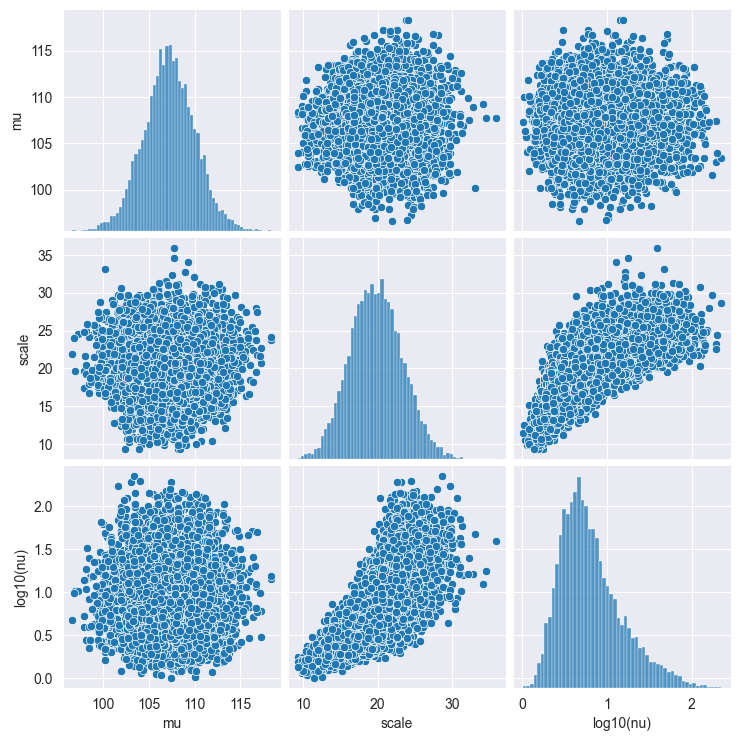

In [31]:
imsi = pd.DataFrame({'mu': trace2['mu'], 
                     'scale': trace2['sigma'], 
                     'log10(nu)': np.log10(trace2['nu'])})
sns.pairplot(imsi);

In [32]:
# correlation
imsi.corr()

,mu,scale,log10(nu)
mu,1.000000,0.007748,0.018905
scale,0.007748,1.000000,0.732385
log10(nu),0.018905,0.732385,1.000000


Notice the strong positive correlation of scale ($\sigma$) and \$log_{10}(\nu)$

## 16.3 - Two Groups

#### Model (Kruschke, 2015)

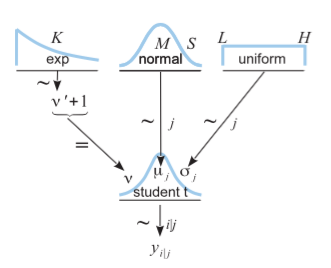

In [33]:
Image('images/fig16_11.png', width=400)

#### Data for Two Group Comparison
- will compare the groups of two categories
- The effect size in this book is defined to be (page 470):

$$
    \frac{\mu_2 - \mu_1}{\sqrt{(\sigma_1^2+\sigma_2^2)\big/2}}
$$

- Effect size (here, it is Cohen's d. See [https://en.wikipedia.org/wiki/Effect_size](https://en.wikipedia.org/wiki/Effect_size))
    $$
        d = \frac{\mu_2 - \mu_1}{s}, \quad\quad
        s = \sqrt{\frac{(n_1 - 1) s_1^2 + (n_2-2) s_2^2}{n_1 + n_2 - 2}}
    $$
    where $s$ is the pooled standard deviation.
    $$
        \mbox{effect size} = \frac{\mbox{mean of test group} - \mbox{mean of control group}}{std}
    $$
    - from [It's the Effect Size, Stupid What effect size is and why it is important](https://www.leeds.ac.uk/educol/documents/00002182.htm#:~:text=Effect%20size%20is%20a%20simple,confounding%20this%20with%20sample%20size.&text=A%20number%20of%20alternative%20measures%20of%20effect%20size%20are%20described.)
        - Effect size is a simple way of quantifying the difference between two groups that has many advantages over the use of tests of statistical significance alone. 
        - Effect size emphasises the size of the difference rather than confounding this with sample size.
        - The paper is w.r.t Frequentist's point of view. But we can compute its posterior distribution thanks to the development of PPL.

In [34]:
grp_idx = df.Group.cat.codes.values
grp_codes = df.Group.cat.categories
n_grps = grp_codes.size
print('grp_idx:  ', grp_idx)
print('grp_codes:', grp_codes)
print('n_grps:   ', n_grps)

grp_idx:   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
grp_codes: Index(['Placebo', 'Smart Drug'], dtype='object')
n_grps:    2


In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder().fit(df.Group)
df['gids'] = le.transform(df.Group)
ngroups = len(le.classes_)
print('ngroups: ', ngroups)
df.tail(2)

ngroups:  2


,Score,Group,gids
118,93,Placebo,0
119,72,Placebo,0


In [36]:
def model3(y, gids, ngroups):
    ym, ys = y.mean(), y.std()
    
    with numpyro.plate(f'g:{ngroups}', size=ngroups):
        mu = numpyro.sample('mu', dist.Normal(ym, ys))
        sigma = numpyro.sample('sigma', dist.Uniform(ys/1000., ys*1000.))
        
    # the same deg. freedom. for the two groups
    nu_minus1 = numpyro.sample('nu_m1', dist.Exponential(1./29))
    nu = numpyro.deterministic('nu', nu_minus1 + 1)  # nu > 1
    
    mus = mu[gids]     #
    sigmas = sigma[gids]
    
    effsiz = numpyro.deterministic('effsize',
                                  (mu[1] - mu[0]) / jnp.sqrt( (sigma[0]**2 + sigma[1]**2)/2. )
                                  )
    with numpyro.plate(f'y:{len(y)}', size=len(y)):
        obs = numpyro.sample('obs', dist.StudentT(df=nu, loc=mus, scale=sigmas), obs=y)

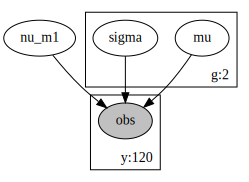

In [37]:
numpyro.render_model(model3, model_args=(df.Score.values, df.gids.values, ngroups))

In [38]:
args = dict(y=df.Score.values, gids=df.gids.values, ngroups=ngroups)
mcmc3 = mcmcinf(model3, args)

sample: 100%|██████████| 11000/11000 [00:12<00:00, 916.00it/s, 7 steps of size 5.62e-01. acc. prob=0.92] 



                mean       std    median     10.0%     90.0%     n_eff     r_hat
     mu[0]     99.30      1.77     99.31     96.94    101.46   9322.81      1.00
     mu[1]    107.09      2.64    107.08    103.76    110.46  11275.53      1.00
     nu_m1      2.94      1.80      2.54      1.01      4.08   6357.33      1.00
  sigma[0]     11.36      1.75     11.23      8.97     13.30   8561.70      1.00
  sigma[1]     17.97      2.73     17.83     14.30     21.10   8274.61      1.00

Number of divergences: 0


In [39]:
mcmc3.print_summary(exclude_deterministic=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   effsize      0.53      0.22      0.52      0.16      0.88  10899.28      1.00
     mu[0]     99.30      1.77     99.31     96.35    102.19   9322.81      1.00
     mu[1]    107.09      2.64    107.08    102.82    111.36  11275.53      1.00
        nu      3.94      1.80      3.54      1.75      5.96   6357.33      1.00
     nu_m1      2.94      1.80      2.54      0.75      4.96   6357.33      1.00
  sigma[0]     11.36      1.75     11.23      8.56     14.15   8561.70      1.00
  sigma[1]     17.97      2.73     17.83     13.69     22.37   8274.61      1.00

Number of divergences: 0


In [40]:
trace3 = get_trace(mcmc3)
# trace3
[v.shape for k, v in trace3.items()]

[(10000,), (10000, 2), (10000,), (10000,), (10000, 2)]


[(10000,), (1, 10000, 2), (10000,), (10000,), (1, 10000, 2)]

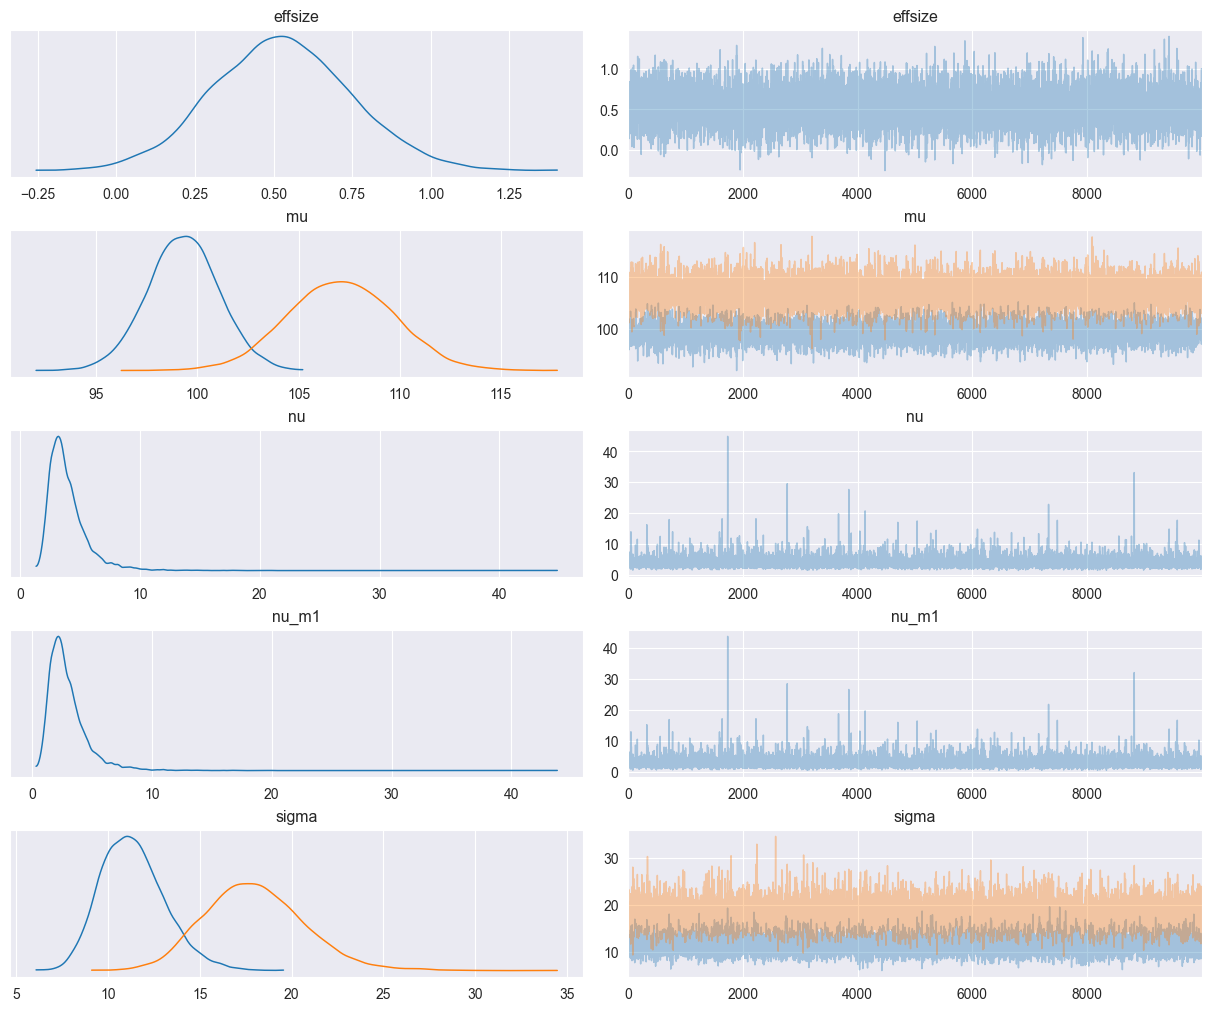

In [41]:
xtrace3 = az.from_numpyro(mcmc3)
az.plot_trace(xtrace3);

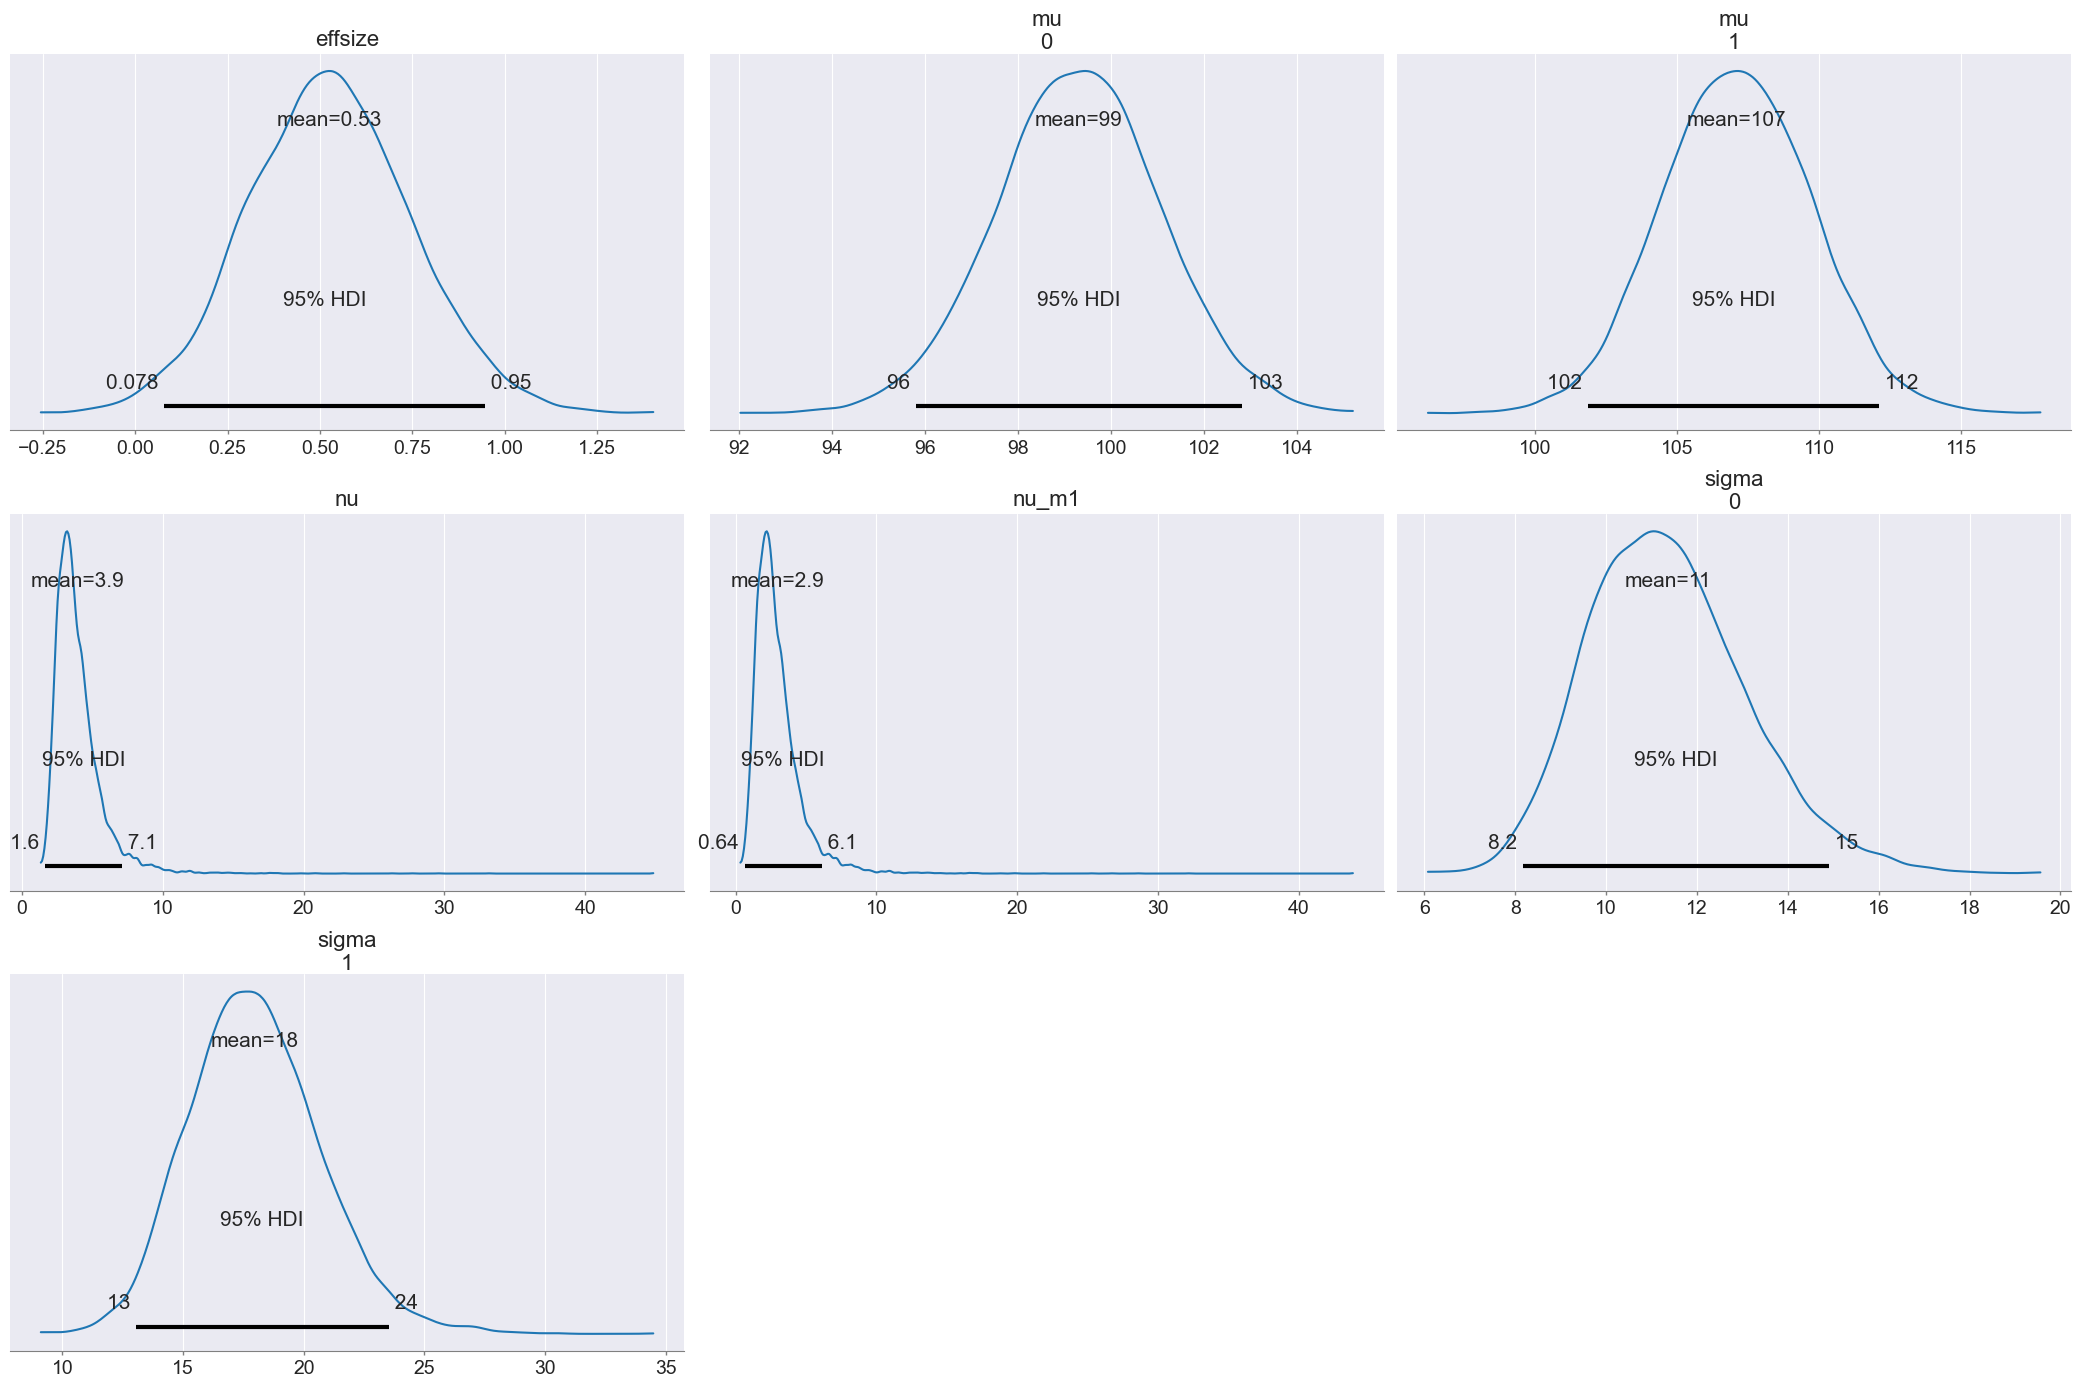

In [42]:
az.plot_posterior(xtrace3, hdi_prob=0.95);

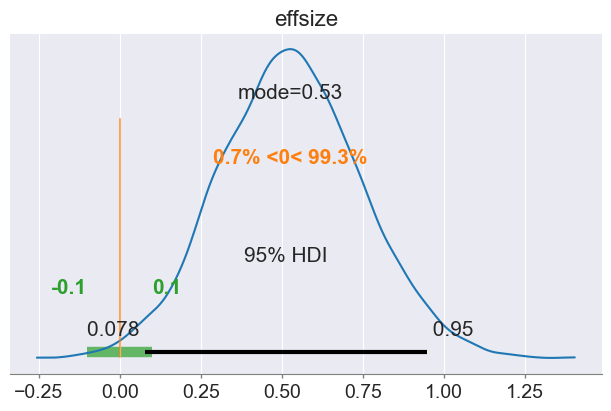

In [43]:
az.plot_posterior(xtrace3, hdi_prob=0.95, 
                  var_names=['effsize'], 
                  point_estimate='mode', 
                  ref_val=0, 
                  rope=[-.1, .1]);

In [44]:
es = trace3['effsize']
np.array([sum(es<-.1) , sum((-.1 < es) & (es < .1)) , sum(es > .1)]) * 100 / len(es)

array([ 0.18,  2.48, 97.34])

#### Figure 16.12

In [45]:
trace3 = get_trace(mcmc3, expand=False)

[(10000,), (10000, 2), (10000,), (10000,), (10000, 2)]


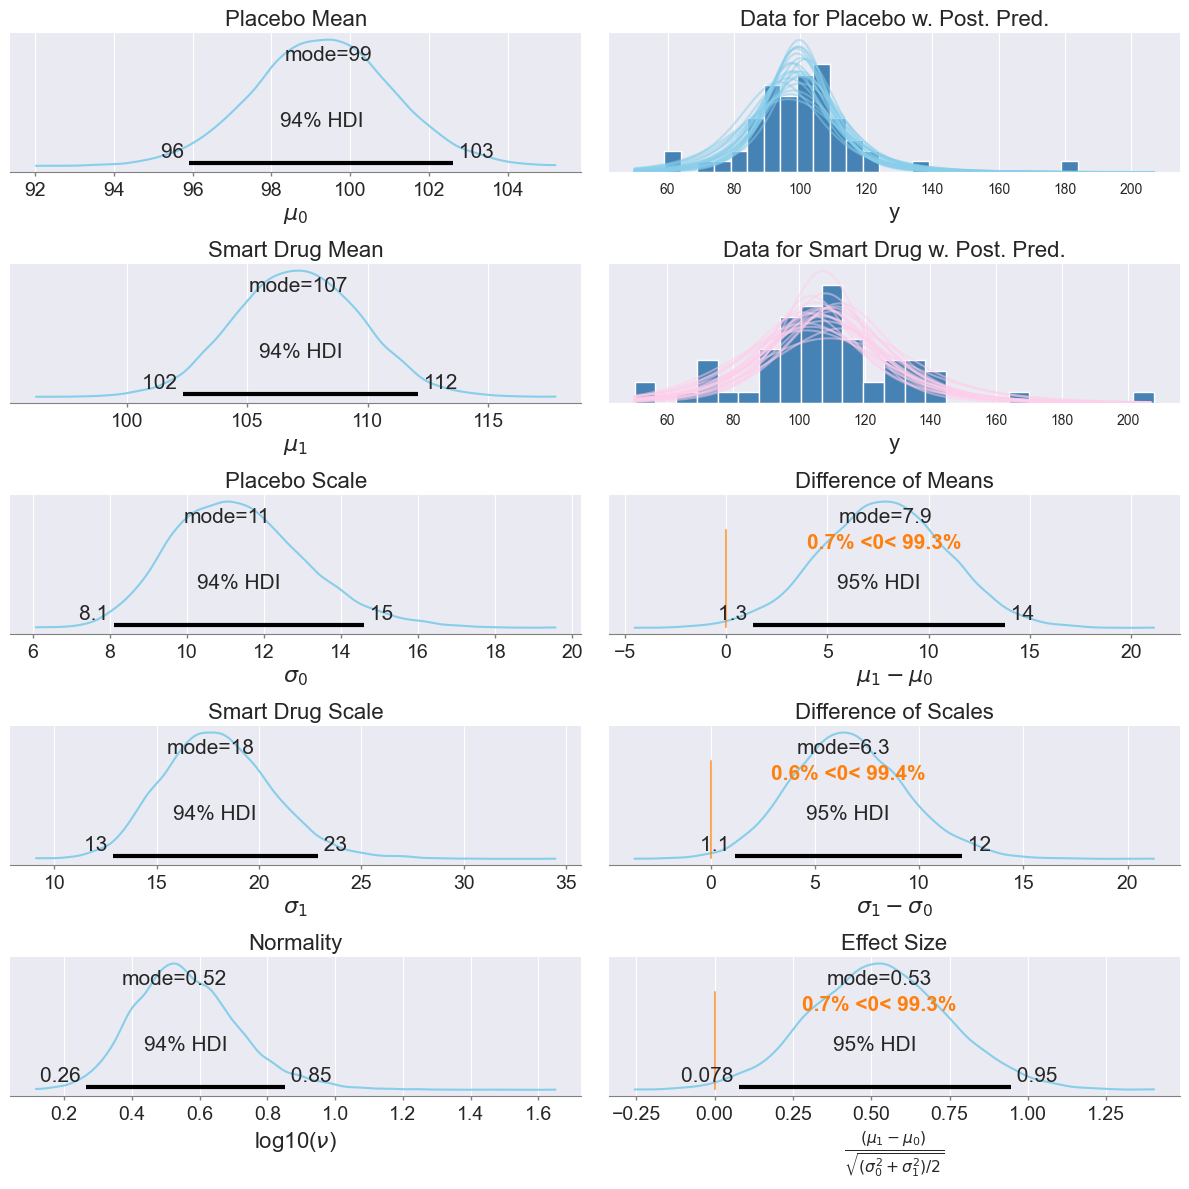

In [46]:
tr3_mu0 = trace3['mu'][:,0]
tr3_mu1 = trace3['mu'][:,1]
tr3_sigma0 = trace3['sigma'][:,0]
tr3_sigma1 = trace3['sigma'][:,1]
tr3_nu = np.log10(trace3['nu'])

fig, axes = plt.subplots(5,2, figsize=(12, 12))

# Left column figs
l_trace_vars = (tr3_mu0, tr3_mu1, tr3_sigma0, tr3_sigma1, tr3_nu)
l_axes_idx = np.arange(5)
l_xlabels = ('$\mu_0$', '$\mu_1$', '$\sigma_0$', '$\sigma_1$', r'log10($\nu$)')
l_titles = ('Placebo Mean', 'Smart Drug Mean', 'Placebo Scale', 'Smart Drug Scale', 'Normality')

for var, ax_i, xlabel, title in zip(l_trace_vars, l_axes_idx, l_xlabels, l_titles): 
    az.plot_posterior(var, point_estimate='mode', ax=axes[ax_i,0], color=color)
    axes[ax_i,0].set_xlabel(xlabel, font_d)
    axes[ax_i,0].set_title(title, font_d)

# Right column figs
tr_len = len(trace3['nu'])
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# print(f'tr_len={tr_len} stepIdxVec=', stepIdxVec)

x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

# 1
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, density=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, 
                        loc=tr3_mu0[stepIdxVec], 
                        scale=tr3_sigma0[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), 
               c='#87ceeb', alpha=.5)
axes[0,1].set_xlabel('y', font_d)
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', font_d)

# 2
axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, density=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1[stepIdxVec], scale=tr3_sigma1[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#ffceeb', alpha=.5)
axes[1,1].set_xlabel('y', font_d)
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', font_d)

# 3-5
r_vars = (tr3_mu1-tr3_mu0,
          tr3_sigma1-tr3_sigma0,
          (tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2))
r_axes_idx = np.arange(start=2, stop=5)
r_xlabels = ('$\mu_1 - \mu_0$',
             '$\sigma_1 - \sigma_0$',
             r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$')
r_titles = ('Difference of Means',
            'Difference of Scales',
            'Effect Size')

for var, ax_i, xlabel, title in zip(r_vars, r_axes_idx, r_xlabels, r_titles):
    az.plot_posterior(var, point_estimate='mode', ref_val=0, hdi_prob=.95, ax=axes[ax_i,1], color=color)
    axes[ax_i,1].set_xlabel(xlabel, font_d)
    axes[ax_i,1].set_title(title, font_d)

plt.tight_layout();

In [47]:
trace3['mu'][:,0].size

10000

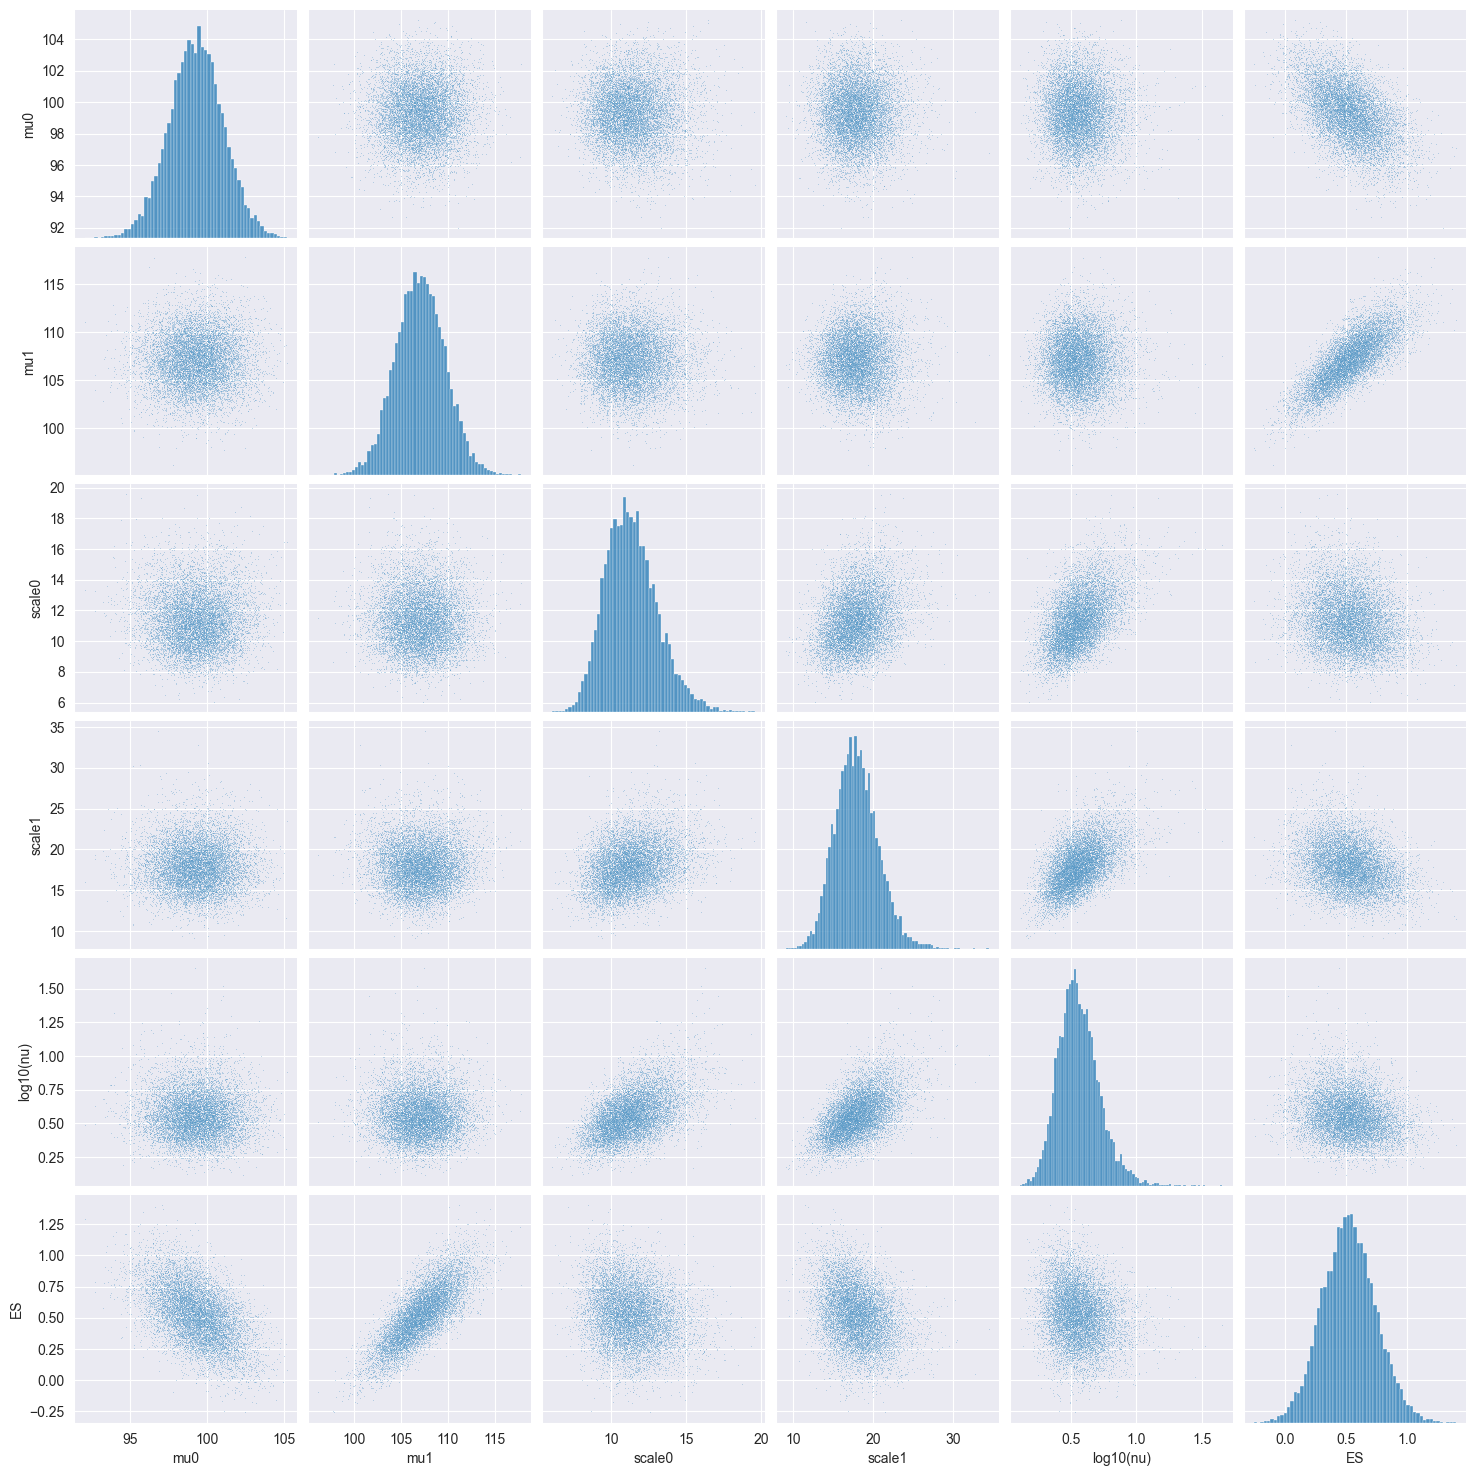

In [48]:
imsi = pd.DataFrame({'mu0': trace3['mu'][:,0], 'mu1' : trace3['mu'][:,1], 
                     'scale0': trace3['sigma'][:,0], 'scale1': trace3['sigma'][:,1], 
                     'log10(nu)': np.log10(trace3['nu']),
                     'ES': trace3['effsize']
                    })
sns.pairplot(imsi, plot_kws={'s': .2});

End.

##### 16.3.1 Analysis by NHST

In [49]:
grouped = df.groupby(df.Group)
grouped.get_group('Placebo')[:2]

,Score,Group,gids
63,109,Placebo,0
64,98,Placebo,0


In [50]:
stats.ttest_ind(grouped.get_group('Placebo').Score, grouped.get_group('Smart Drug').Score,
               equal_var=False)

Ttest_indResult(statistic=-1.9579876350511547, pvalue=0.05273105236398135)

In [51]:
imsi = [grouped.get_group(s).Score for s in df.Group.cat.categories]
# print(imsi)
stats.ttest_ind(imsi[0], imsi[1],
               equal_var=False)

Ttest_indResult(statistic=-1.9579876350511547, pvalue=0.05273105236398135)